In [20]:
# =========================================================
# 0. 匯入套件 & 基本設定
# =========================================================
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

import sys
sys.path.append('../model')  # 根據 notebook 路徑調整
from network_v2 import create_model
import yaml

target_dir = "HV"
target = "HV_A-D+calcDensity"

# model 相關參數
MODEL_NAME = "roberta-base"   # 換成 config['model']['name_or_path']  "m3rg-iitd/matscibert"
MAX_LEN = 512

CKPT_PATH = f"model/finetune_{target_dir}/{target}/model.pt"  # 換成實際 ckpt 路徑
config_path = f'model/finetune_{target_dir}/{target}/config.yaml'

# dataset 相關參數
CSV_SENT_PATH = f"sentence/vl_all_data_{target_dir}_sentence.csv"  # val sentence 資料




# =========================================================
# 3. 讀取 val sentence 資料
#    假設每一欄就是一個 sentence，例如：
#    FORMULA, PROPERTY: Microstructure, PROPERTY: HV, ...
# =========================================================
df_val_sent = pd.read_csv(CSV_SENT_PATH)
print("val sentence shape:", df_val_sent.shape)


# =========================================================
# 4. 定義欄位（sentence）順序：你想要出現在 heatmap 的軸上
#    請確認這些欄位名稱有在 CSV 裡
# =========================================================

SENTENCE_KEYS = [
    "FORMULA",                                      # A
    "PROPERTY: Processing method",                  # B
    "PROPERTY: Type of test",                       # C
    "PROPERTY: Test temperature ($^\\circ$C)",      # D
    # "PROPERTY: Microstructure",                     # G "PROPERTY: BCC/FCC/other"會合併進來
    # "PROPERTY: BCC/FCC/other",
    # "PROPERTY: Grain size ($\\mu$m)",
    # "PROPERTY: Exp. Density (g/cm$^3$)",
    "PROPERTY: Calculated Density (g/cm$^3$)",
    # "PROPERTY: HV",
    # "PROPERTY: YS (MPa)",
    # "PROPERTY: UTS (MPa)",
    # "PROPERTY: Elongation (%)",
    # "PROPERTY: Elongation plastic (%)",
    # "PROPERTY: Exp. Young modulus (GPa)",
    # "PROPERTY: Calculated Young modulus (GPa)",
]

# 過濾出「真正在 CSV 裡存在」的欄位
USED_KEYS_IN_DF = [k for k in SENTENCE_KEYS if k in df_val_sent.columns]
print("Will use keys:", USED_KEYS_IN_DF)

df_val_sent.head()

val sentence shape: (65, 14)
Will use keys: ['FORMULA', 'PROPERTY: Processing method', 'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\\circ$C)', 'PROPERTY: Calculated Density (g/cm$^3$)']


,target,PROPERTY: Type of test,PROPERTY: Calculated Density (g/cm$^3$),PROPERTY: Processing method,PROPERTY: Calculated Young modulus (GPa),PROPERTY: YS (MPa),PROPERTY: UTS (MPa),PROPERTY: Elongation (%),FORMULA,PROPERTY: Microstructure,PROPERTY: Test temperature ($^\circ$C),PROPERTY: Exp. Density (g/cm$^3$),PROPERTY: Exp. Young modulus (GPa),PROPERTY: Elongation plastic (%)
0,0.343173,The alloy was tested in C test.,Calculated density of the alloy is 6.5 g/cm^3.,Processing method of the alloy is CAST.Liquid ...,Calculated Young modulus of the alloy is 94.0GPa.,Yield Strength (YS) of alloy is 1223.0MPa.,Unknown,Unknown,Alloy's formula is Nb1 Ti1 Zr1.,Microstructure of alloy is BCC.Atoms arranged ...,Alloy as tested at 25.0 Celsius.,Unknown,Unknown,Unknown
1,0.296125,Unknown,Calculated density of the alloy is 7.319238709...,Unknown,Calculated Young modulus of the alloy is 181.8...,Unknown,Unknown,Unknown,Alloy's formula is Al0.5 Co1 Cr1 Cu1 Fe1 Ni1 T...,Microstructure of alloy is FCC.Atoms arranged ...,Alloy as tested at 25.0 Celsius.,Experimental density of the alloy is 7.3 g/cm^3.,Unknown,Unknown
2,0.728782,Unknown,Calculated density of the alloy is 6.2 g/cm^3.,Processing method of the alloy is CAST.Liquid ...,Calculated Young modulus of the alloy is 129.0...,Unknown,Unknown,Unknown,Alloy's formula is Al1 Co1 Fe1 Ni1 Ti1 V1 Zr1.,Microstructure of alloy is BCC.Atoms arranged ...,Alloy as tested at 25.0 Celsius.,Unknown,Unknown,Unknown
3,0.547970,Unknown,Calculated density of the alloy is 7.2 g/cm^3.,Processing method of the alloy is CAST.Liquid ...,Calculated Young modulus of the alloy is 174.0...,Unknown,Unknown,Unknown,Alloy's formula is Al0.312 Co0.625 Cr0.625 Cu0...,Microstructure of alloy is BCC.Atoms arranged ...,Alloy as tested at 25.0 Celsius.,Unknown,Unknown,Unknown
4,0.436347,The alloy was tested in C test.,Calculated density of the alloy is 13.7 g/cm^3.,Processing method of the alloy is CAST.Liquid ...,Calculated Young modulus of the alloy is 298.0...,Yield Strength (YS) of alloy is 896.0MPa.,Unknown,The alloy has 10.4% elongation.,Alloy's formula is Mo1 Nb1 Re0.5 W1.,Microstructure of alloy is BCC.Atoms arranged ...,Alloy as tested at 25.0 Celsius.,Unknown,Unknown,Plastic elongation of the alloy is 7.08%.


In [21]:
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
config['device'] = str(DEVICE)
print("Device:", DEVICE)

# 2. 構建 tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    config['paths']['tokenizer'],
    model_max_length=512
)

# 3. 構建模型
model = create_model(config)
ckpt = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=False)
state_dict = ckpt['model_state_dict']

# # 處理 DDP/Accelerate 前綴
clean_sd = {k.replace('module.', ''): v for k, v in state_dict.items()}
# model.load_state_dict(clean_sd, strict=False)

# ===== 作法 C：把舊 network.py 的 key 轉成 network_v2 的命名 =====
converted_sd = {}
for k, v in clean_sd.items():
    if k.startswith("roberta."):
        # roberta.xxx → backbone.xxx
        new_k = "backbone." + k[len("roberta."):]
        converted_sd[new_k] = v
    elif k.startswith("head.0."):
        # head.0.weight / head.0.bias → head.weight / head.bias
        new_k = "head." + k[len("head.0."):]
        converted_sd[new_k] = v
    else:
        # 其他就照舊保留（例如之後你用 network_v2 訓練的 ckpt，本來就叫 backbone. / head.）
        converted_sd[k] = v

# 載入轉換後的權重
missing, unexpected = model.load_state_dict(converted_sd, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.to(DEVICE)
model.eval()

Device: cpu
Missing keys: []
Unexpected keys: []


AlloyRegressor(
  (backbone): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Lay

In [22]:
# =========================================================
# 5. 工具函式：由一筆 row 建立 full_text & 每個欄位的字元範圍 spans
# =========================================================

def build_full_text_and_spans(row, key_list):
    """
    row: df_val_sent.iloc[i]
    key_list: 欲使用的欄位順序
    回傳:
        full_text: 把有值的 sentence 串起來
        spans: dict[key] = (start_char, end_char) 在 full_text 的位置
        used_keys: 真正有 sentence 的欄位（subset of key_list，且有值）
    """
    parts = []
    spans = {}
    used_keys = []
    cursor = 0

    for key in key_list:
        if key not in row:
            continue
        val = row[key]
        if pd.isna(val):
            print(f"Warning: key '{key}' is NaN, skipping.")
            continue
        s = str(val)
        if len(parts) > 0:
            # 前面有東西，就先放一個空白分隔
            parts.append(" ")
            cursor += 1
        start = cursor
        parts.append(s)
        end = start + len(s)
        spans[key] = (start, end)
        used_keys.append(key)
        cursor = end

    full_text = "".join(parts)
    return full_text, spans, used_keys

# =========================================================
# 6. 工具函式：計算某一筆樣本的 sentence×sentence attention 矩陣
# =========================================================

def compute_sentence_attention(row, key_list, layer=-1):
    """
    row: df_val_sent.iloc[i]
    key_list: 欲考慮的欄位順序（例如 USED_KEYS_IN_DF）
    layer: 要看的 attention layer（預設 -1: 最後一層）

    回傳:
        mat: [num_sent, num_sent] 的 numpy array（row-wise normalized）
        used_keys: 真正有 sentence 的欄位 list
        full_text: 給你 debug/檢查用
        pred: 該 sample 的模型預測值
    """
    # 1) 組出 full_text + span
    full_text, spans, used_keys = build_full_text_and_spans(row, key_list)
    if len(used_keys) == 0:
        raise ValueError("這筆資料沒有任何有效的 sentence 欄位。")

    # 2) tokenization + offset
    enc = tokenizer(
        full_text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LEN,
        return_offsets_mapping=True
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}
    offsets = enc["offset_mapping"][0].tolist()  # list of (start_char, end_char)

    # 3) forward with attention
    with torch.no_grad():
        logits, attentions = model.forward_with_attn(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"]
        )
    pred = float(logits.squeeze().cpu().item())

    # 4) 取指定層，平均 head
    # attentions: list[num_layers] -> [batch, heads, seq, seq]
    attn_layer = attentions[layer][0].mean(dim=0).detach().cpu()  # [seq, seq]

    # 5) 每個 token 判斷屬於哪個欄位（用 char span 判斷有無重疊）
    token_to_key = []
    for (ts, te) in offsets:
        tok_key = None
        for key, (ss, se) in spans.items():
            # 有重疊就算這個 key
            if not (te <= ss or ts >= se):
                tok_key = key
                break
        token_to_key.append(tok_key)

    # 6) 聚合到 sentence-level
    n = len(used_keys)
    key_to_idx = {k: i for i, k in enumerate(used_keys)}
    mat = np.zeros((n, n), dtype=float)

    seq_len = attn_layer.shape[0]
    for qi in range(seq_len):
        qk = token_to_key[qi]
        if qk is None:
            continue
        q_idx = key_to_idx[qk]
        for ki in range(seq_len):
            kk = token_to_key[ki]
            if kk is None:
                continue
            k_idx = key_to_idx[kk]
            mat[q_idx, k_idx] += float(attn_layer[qi, ki])

    # 7) row-wise normalize（讓每個 query sentence 的 attention sum = 1）
    for i in range(n):
        s = mat[i].sum()
        if s > 0:
            mat[i] /= s

    return mat, used_keys, full_text, pred


# =========================================================
# 7. 工具函式：計算整個 val set 的平均 attention 矩陣
# =========================================================
def compute_valset_average_attention_matrix(df, key_list, layer=-1):
    """
    df: validation sentence dataframe（df_val_sent）
    key_list: 欄位順序（USED_KEYS_IN_DF）
    layer: attention 層（預設最後一層）

    回傳：
        avg_mat: 平均 attention 矩陣 (n x n)
        used_keys: 欄位名稱順序
        valid_count: 有效樣本量
    """
    total_mat = None
    valid_count = 0
    used_keys_global = None

    for i in range(len(df)):
        row = df.iloc[i]

        try:
            mat, used_keys, _, _ = compute_sentence_attention(row, key_list, layer=layer)
        except:
            continue

        if total_mat is None:
            total_mat = np.zeros_like(mat)
            used_keys_global = used_keys

        total_mat += mat
        valid_count += 1

    if valid_count == 0:
        raise ValueError("沒有任何有效的樣本可計算 average attention。")

    avg_mat = total_mat / valid_count
    return avg_mat, used_keys_global, valid_count


In [23]:
def plot_attention_heatmap(avg_mat, used_keys, 
                                   title="Average Feature Attention (Validation Set)"):
    n = len(used_keys)

    # plt.figure(figsize=(n * 1.2, n * 1.2))
    plt.figure(figsize=(10, 10))
    plt.imshow(avg_mat, cmap="viridis")
    cbar = plt.colorbar()
    cbar.set_label("Attention Ratio",  # Normalized attention
                   fontsize=16)

    plt.xticks(
        range(n), 
        used_keys, 
        rotation=45,          # 斜 45 度
        ha="right",           # 向右對齊
        fontsize=12, 
        # fontstyle="italic"    # 斜體字
    )

    plt.yticks(
        range(n), 
        used_keys,
        fontsize=12,
        # fontstyle="italic"    # 斜體字
    )

    plt.grid(False)           # 讓格子之間更清晰

    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()


def plot_attention_bar(avg_mat, used_keys, 
                               title="Average Feature Attention (Validation Set)"):
    """
    avg_mat: (n x n) 平均 attention matrix
    used_keys: 欄位名稱
    """
    # 欄位被注意的程度 = column sum
    attention_scores = avg_mat.sum(axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(used_keys, attention_scores, color="steelblue")

    plt.xticks(rotation=45, ha="right", fontsize=12)
    
    plt.ylabel("Average Attention Score", fontsize=12)
    plt.title(title, fontsize=16)

    plt.tight_layout()
    plt.show()


# =========================================================
# draw single and average
# =========================================================
def draw_single_sample_attention(idx, target, key_list=USED_KEYS_IN_DF, layer=-1):
    """
    idx: df_val_sent 的 index（iloc 的位置）
    key_list: 欄位列表（預設用 USED_KEYS_IN_DF）
    layer: attention 層（預設最後一層）
    """
    row = df_val_sent.iloc[idx]
    mat, used_keys, full_text, pred = compute_sentence_attention(row, key_list, layer=layer)

    print(f"Sample index: {idx}")
    print(f"Model prediction: {pred:.4f}")
    print("Used keys:", used_keys)
    print("Full text:\n", full_text)
    print()

    # 畫 heatmap
    # plot_attention_heatmap(mat, used_keys, title=f"Feature Attention (layer {layer if layer >= 0 else 'last'})")
    plot_attention_heatmap(mat, used_keys, title=f"Feature Attention ({target}) (index={idx})")

    # 畫直方圖---------- Attention bar chart ----------
    plot_attention_bar(
        mat,
        used_keys,
        title=f"Feature Attention Scores ({target}) (index={idx})"
    )   
    
def draw_average_attention(target, key_list=USED_KEYS_IN_DF, layer=-1):
    """
    key_list: 欄位列表（預設用 USED_KEYS_IN_DF）
    layer: attention 層（預設最後一層）
    """
    avg_mat, avg_keys, count = compute_valset_average_attention_matrix(
    df_val_sent, 
    USED_KEYS_IN_DF,
    layer=-1 # 最後一層 attention
    )

    print(f"有效樣本數：{count}")
    print("使用欄位順序：", avg_keys)

    # 畫 heatmap
    plot_attention_heatmap(avg_mat, avg_keys, 
                                   title=f"Average Feature Attention ({target} Validation Set)")

    # 畫 直方圖
    plot_attention_bar(avg_mat, avg_keys, 
                               title=f"Average Feature Attention ({target} Validation Set)") 

有效樣本數：65
使用欄位順序： ['FORMULA', 'PROPERTY: Processing method', 'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\\circ$C)', 'PROPERTY: Calculated Density (g/cm$^3$)']


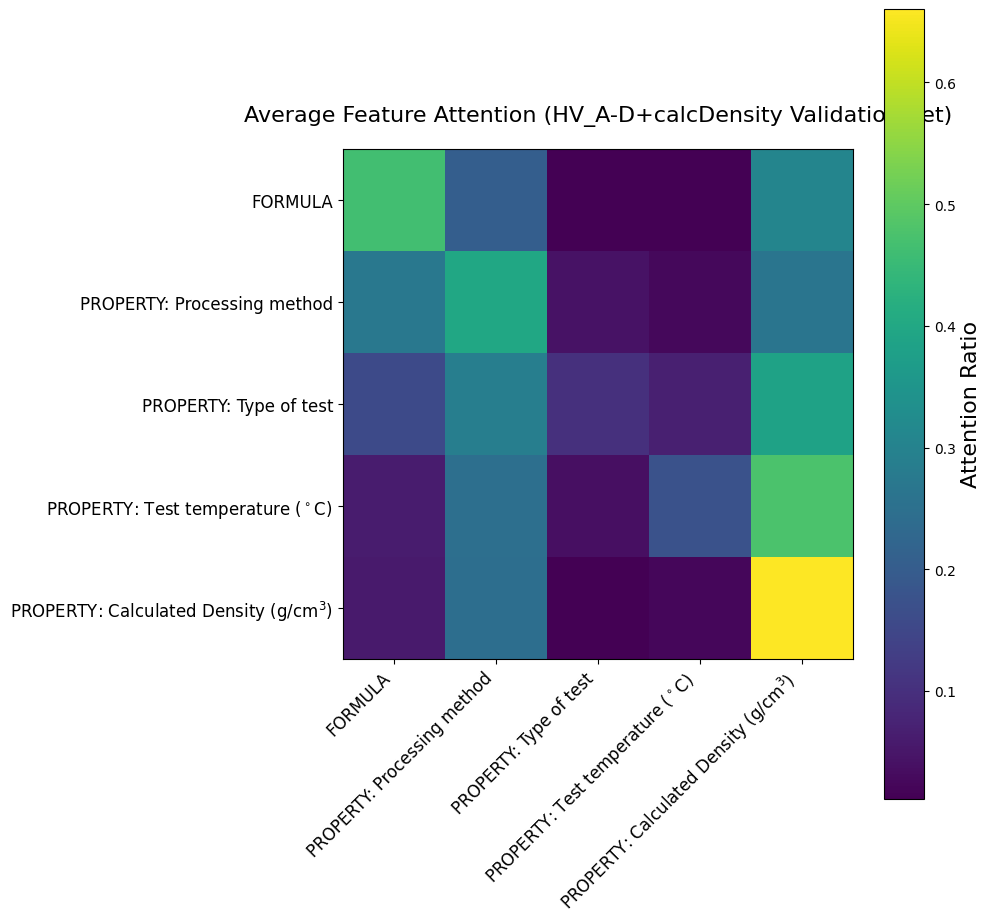

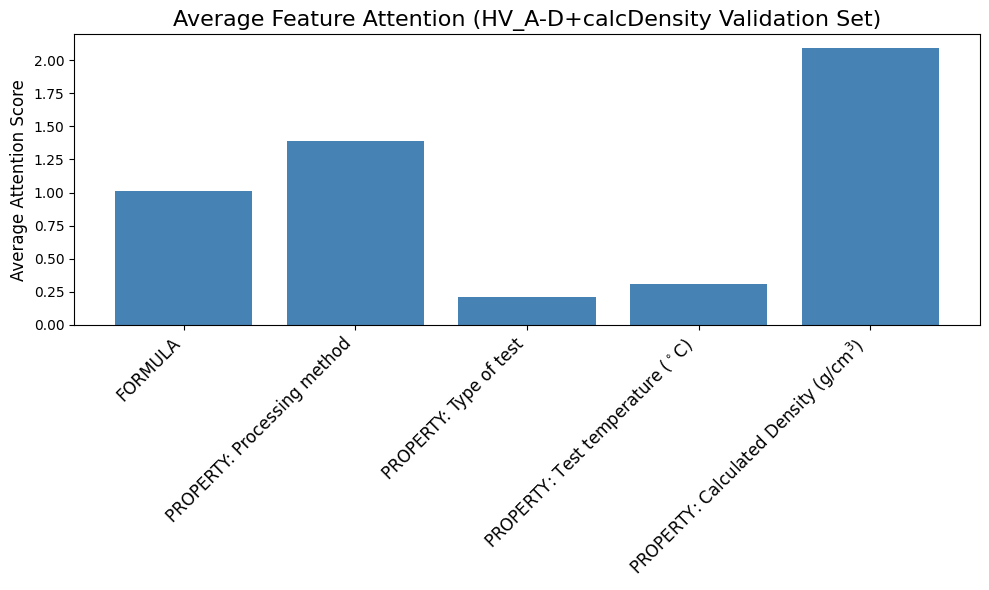

In [24]:
# =========================================================
# 對第 0 筆 val 資料畫 attention heatmap
# 可以改成其它 index，例如 5, 10, 100 ...
# =========================================================
# draw_single_sample_attention(idx=0, key_list=USED_KEYS_IN_DF, layer=-1)

# =========================================================
# 多份平均
# =========================================================
draw_average_attention(target=target, key_list=USED_KEYS_IN_DF, layer=-1)



In [25]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 讀取 best_predictions.csv
# df = pd.read_csv('training_output/.../best_predictions.csv')  # 請填入實際路徑

# # 假設有 target_raw（原始值）和 y_pred（預測值）欄位
# plt.figure(figsize=(8,6))
# plt.scatter(df['target_raw'], df['y_pred'], alpha=0.7)
# plt.xlabel('True Value (原始值)')
# plt.ylabel('Predicted Value')
# plt.title('True vs Predicted')
# plt.plot([df['target_raw'].min(), df['target_raw'].max()],
#          [df['target_raw'].min(), df['target_raw'].max()], 'r--')  # 理想線
# plt.show()

# 重新 pred，並畫實際值與預測值 分佈

In [26]:
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# df_train = pd.read_pickle(f'../data/all_data/all_data_{target}/tr_all_data_{target}_text.pkl')
# df_val = pd.read_pickle(f'../data/all_data/all_data_{target}/vl_all_data_{target}_text.pkl')

# train_target_raw = df_train['target_raw'].tolist()
# tmax = max(train_target_raw)
# print("tmax:", tmax)

# # 取得 text、正規化 target、原始 target
# texts = df_val['text'].tolist()
# target_nor = df_val['target'].tolist()  # 正規化後
# target_raw = df_val['target_raw'].tolist()  # 原始值

# print("Val set size:", len(texts))
# print("Val target_nor :", target_nor)
# print("Val target_raw :", target_raw)
# print("=================================")

# # 預測（模型預測的是正規化值）
# model.eval()
# preds_nor = []
# with torch.no_grad():
#     for text in texts:
#         inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=MAX_LEN, padding='max_length')
#         for k in inputs:
#             inputs[k] = inputs[k].to(DEVICE)
#         logits = model(**inputs)
#         pred = logits.squeeze().cpu().item()
#         preds_nor.append(pred)

# # 用 train set 的 tmax 反正規化
# preds_raw = [p * tmax for p in preds_nor]
# print("Preds_nor :", preds_nor)
# print("Preds_raw :", preds_raw)
# print("=================================")

# # 計算正規化 MAE/MSE/R2
# mae_nor = mean_absolute_error(target_nor, preds_nor)
# mse_nor = mean_squared_error(target_nor, preds_nor)
# r2_nor = r2_score(target_nor, preds_nor)
# print(f"正規化 MAE: {mae_nor:.6f}  MSE: {mse_nor:.6f}  R2: {r2_nor:.6f}")
# print("=================================")
# # 計算縮放回去 MAE/MSE/R2

# mae_raw = mean_absolute_error(target_raw, preds_raw)
# mse_raw = mean_squared_error(target_raw, preds_raw)
# r2_raw = r2_score(target_raw, preds_raw)
# print(f"縮放回原始 MAE: {mae_raw:.6f}  MSE: {mse_raw:.6f}  R2: {r2_raw:.6f}")

# # 畫圖（用縮放回去的 preds_raw）
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,6))
# plt.scatter(target_raw, preds_raw, alpha=0.7)
# plt.xlabel('True Value')
# plt.ylabel('Predicted Value')
# plt.title('True vs Predicted')
# plt.plot([min(target_raw), max(target_raw)], [min(target_raw), max(target_raw)], 'r--')
# plt.show()